<a href="https://colab.research.google.com/github/duhajarrar/SmartPlantDiseaseDetector_Ai/blob/main/PlantVillage_with_swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
import os
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split




import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import albumentations as album

from PIL import Image


In [ ]:

#upload the token from kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rabeeqasem","key":"7991329f95669d4f6f8bdd0108b57e7e"}'}

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
## Download the dataset
!kaggle datasets download -d emmarex/plantdisease

100% 655M/658M [00:17<00:00, 39.0MB/s]
100% 658M/658M [00:17<00:00, 40.0MB/s]


In [ ]:
zip_name='/content/plantdisease.zip'
with ZipFile(zip_name, 'r') as zip:
  zip.extractall()
  print('done')


done


In [ ]:
#data set path
data_path='/content/PlantVillage'
os.chdir(data_path)

#EDA

In [ ]:
classes=list(os.listdir())
classes

['Tomato__Target_Spot',
 'Tomato_Late_blight',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mold',
 'Potato___healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Potato___Early_blight']

In [ ]:
#len(list(os.listdir(os.path.join(data_path,classes[0]))))
bar_dict={}
for c in classes:
  bar_dict[c]=len(list(os.listdir(os.path.join(data_path,c))))
bar_dict



{'Tomato__Target_Spot': 1404,
 'Tomato_Late_blight': 1909,
 'Pepper__bell___healthy': 1478,
 'Potato___Late_blight': 1000,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676,
 'Pepper__bell___Bacterial_spot': 997,
 'Tomato_Septoria_leaf_spot': 1771,
 'Tomato_Leaf_Mold': 952,
 'Potato___healthy': 152,
 'Tomato__Tomato_mosaic_virus': 373,
 'Tomato_Bacterial_spot': 2127,
 'Tomato_Early_blight': 1000,
 'Tomato_healthy': 1591,
 'Potato___Early_blight': 1000}

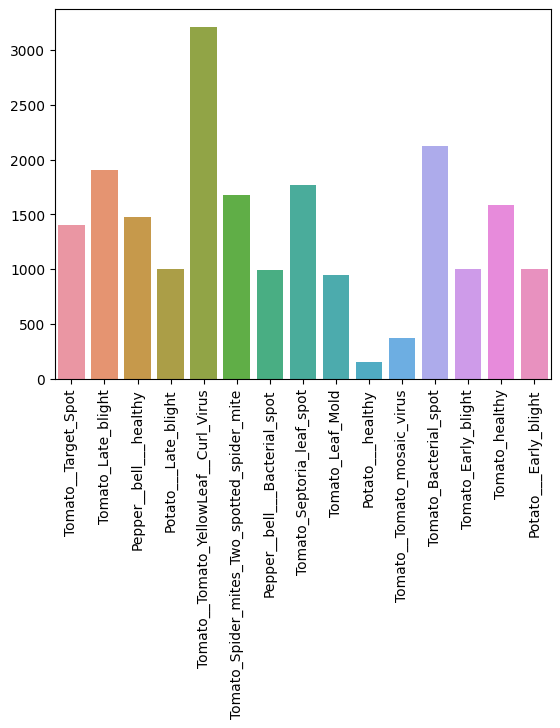

In [ ]:
sns.barplot(x=list(bar_dict.keys()),y=list(bar_dict.values()))
plt.xticks(rotation=90)
plt.show()
#from the graph below the data inplance we need to handl it

In [ ]:
#lets create a dataframe that have all the information that we have on the images the image path and the class

dataframe_list=[]
for index,c in enumerate(classes):
  for imag_name in list(os.listdir(os.path.join(data_path,c))):
    image_path=os.path.join(os.path.join(data_path,c,imag_name))
    photo_format=image_path.split('.')
    if photo_format[-1] in ['JPG','jpg','jpeg','png']:
      dataframe_list.append([image_path,photo_format[-1],index,c])

datainf=pd.DataFrame(dataframe_list,columns=['image_path','photo_format','label_id','class'])


In [ ]:
datainf

,image_path,photo_format,label_id,class
0,/content/PlantVillage/Tomato__Target_Spot/b139...,JPG,0,Tomato__Target_Spot
1,/content/PlantVillage/Tomato__Target_Spot/c6fc...,JPG,0,Tomato__Target_Spot
2,/content/PlantVillage/Tomato__Target_Spot/d883...,JPG,0,Tomato__Target_Spot
3,/content/PlantVillage/Tomato__Target_Spot/3015...,JPG,0,Tomato__Target_Spot
4,/content/PlantVillage/Tomato__Target_Spot/841b...,JPG,0,Tomato__Target_Spot
...,...,...,...,...
20633,/content/PlantVillage/Potato___Early_blight/1d...,JPG,14,Potato___Early_blight
20634,/content/PlantVillage/Potato___Early_blight/0a...,JPG,14,Potato___Early_blight
20635,/content/PlantVillage/Potato___Early_blight/29...,JPG,14,Potato___Early_blight
20636,/content/PlantVillage/Potato___Early_blight/8c...,JPG,14,Potato___Early_blight


In [ ]:
#check what is the type of photos
datainf['photo_format'].value_counts()

JPG     20482
jpg       154
jpeg        1
png         1
Name: photo_format, dtype: int64

#modeling

In [ ]:
train_df, test_df = train_test_split(datainf, test_size=0.2, random_state=42)
train_df,val_df = train_test_split(train_df, test_size=0.125, random_state=42)


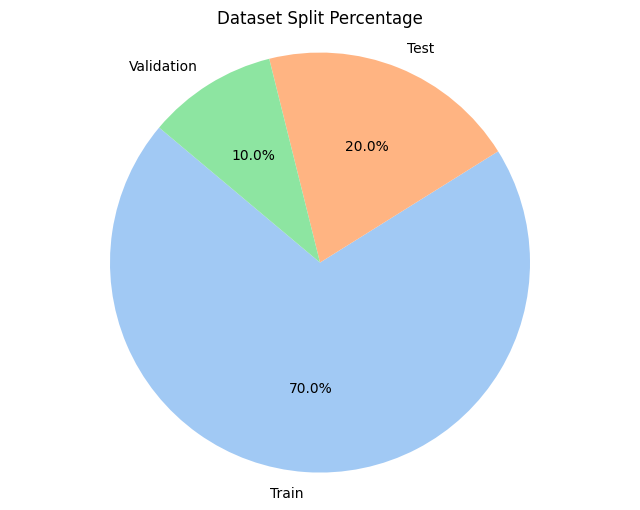

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the sizes of train, test, and validation sets
total_samples = len(datainf)
train_size = len(train_df)
test_size = len(test_df)
val_size = len(val_df)

# Calculate the percentages
train_percent = (train_size / total_samples) * 100
test_percent = (test_size / total_samples) * 100
val_percent = (val_size / total_samples) * 100

# Data for the pie chart
sizes = [train_percent, test_percent, val_percent]
labels = ['Train', 'Test', 'Validation']

# Create the pie chart using Seaborn
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Split Percentage')

# Show the plot
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageClassificationDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 2]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        else:
            # Apply default transformation if transform is not provided
            default_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            image = default_transform(image)

        return image, label




In [ ]:
from torchvision import transforms


#appling the data agumentation on the training dataset
training_transform_function = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Set a non-zero value here
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(),
])

# transform_function=transforms.Compose([
#     transforms.Resize((224, 244)),
#     transforms.ToTensor(),
# ])

train_dataset = ImageClassificationDataset(train_df, transform=training_transform_function)
val_dataset = ImageClassificationDataset(val_df)
test_dataset = ImageClassificationDataset(test_df)

# Create DataLoader instances for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForImageClassification,SegformerConfig
from PIL import Image
import requests

configuration = SegformerConfig()
#feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b5")
segformer_model = SegformerForImageClassification(configuration).from_pretrained("nvidia/mit-b5")
segformer_optimizer = torch.optim.AdamW(segformer_model.parameters(), lr=0.0001)
segformer_model.to(device)


SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)


In [ ]:
from transformers import ResNetConfig, ResNetForImageClassification
configuration = ResNetConfig()
resnet_model=ResNetForImageClassification(configuration).from_pretrained('microsoft/resnet-152')
resnet_optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=0.0001)
resnet_model.to(device)


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
from transformers import PvtConfig, PvtForImageClassification
configuration = PvtConfig()
vit_model=PvtForImageClassification(configuration).from_pretrained('Zetatech/pvt-tiny-224')
vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=0.0001)
vit_model.to(device)


PvtForImageClassification(
  (pvt): PvtModel(
    (encoder): PvtEncoder(
      (patch_embeddings): ModuleList(
        (0): PvtPatchEmbeddings(
          (projection): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
          (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): PvtPatchEmbeddings(
          (projection): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): PvtPatchEmbeddings(
          (projection): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((320,), eps=1e-06, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): PvtPatchEmbeddings(
          (projection): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
          (layer_norm): LayerNorm((512,),

In [ ]:
from transformers import SwinConfig, SwinForImageClassification
configuration = SwinConfig()
swin_model=SwinForImageClassification(configuration).from_pretrained('microsoft/swin-tiny-patch4-window7-224')
swin_optimizer = torch.optim.AdamW(swin_model.parameters(), lr=0.0001)
swin_model.to(device)


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [23]:
from datasets import load_metric
import torch
import torch.nn as nn

from sklearn.metrics import precision_score, recall_score, f1_score

# Load the accuracy metric
metric = load_metric("accuracy")

# Define the number of epochs
num_epochs = 20

# Loss function
loss_function = nn.CrossEntropyLoss()

# Lists to store results
results = []

# Models to train
models = [
    {"name": "Vit", "model": vit_model, "optimizer": vit_optimizer},
     {"name": "swin", "model": swin_model, "optimizer": swin_optimizer},
    {"name": "Segformer", "model": segformer_model, "optimizer": segformer_optimizer},
    {"name": "ResNet", "model": resnet_model, "optimizer": resnet_optimizer},


]

# Training loop
for model_info in models:
    for epoch in range(num_epochs):

        model_name = model_info["name"]
        model = model_info["model"]
        optimizer = model_info["optimizer"]

        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate metrics for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples

        # Print epoch results

        print(f"model_name [{model_name}], Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


        # Validation loop
        model.eval()
        val_correct = 0
        val_samples = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(images)

            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)

        val_accuracy = val_correct / val_samples

        print(f"model: {model_name}, epoch: {epoch + 1}, train_accuracy: {epoch_accuracy}, val_accuracy: {val_accuracy}")
        # ...

    # Test loop
    model.eval()
    test_correct = 0
    test_samples = 0


    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.logits, 1)
        test_correct += (predicted == labels).sum().item()
        test_samples += labels.size(0)

    precision = precision_score(labels.cpu(), predicted.cpu(), average='weighted')
    recall = recall_score(labels.cpu(), predicted.cpu(), average='weighted')
    f1 = f1_score(labels.cpu(), predicted.cpu(), average='weighted')

    test_accuracy = test_correct / test_samples
    print(f"model_name:{model_name} Test Accuracy: {test_accuracy:.4f} precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}")
    print('-----------------------------------------------------------')

    #results.append({"model": model_name, "epoch": epoch + 1, "train_accuracy": epoch_accuracy, "val_accuracy": val_accuracy,"test_accuracy":test_accuracy})
    results.append({
    "model": model_name,
    "epoch": epoch + 1,
    "train_accuracy": epoch_accuracy,
    "val_accuracy": val_accuracy,
    "test_accuracy": test_accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})
    torch.cuda.empty_cache()



<ipython-input-23-f42019990657>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


model_name [Vit], Epoch [1/20] - Loss: 0.4251, Accuracy: 0.8792
model: Vit, epoch: 1, train_accuracy: 0.8792053163505469, val_accuracy: 0.9583333333333334
model_name [Vit], Epoch [2/20] - Loss: 0.1022, Accuracy: 0.9651
model: Vit, epoch: 2, train_accuracy: 0.9651114495362038, val_accuracy: 0.9772286821705426
model_name [Vit], Epoch [3/20] - Loss: 0.0737, Accuracy: 0.9760
model: Vit, epoch: 3, train_accuracy: 0.9760487332133463, val_accuracy: 0.9844961240310077
model_name [Vit], Epoch [4/20] - Loss: 0.0579, Accuracy: 0.9812
model: Vit, epoch: 4, train_accuracy: 0.981171258479856, val_accuracy: 0.9588178294573644
model_name [Vit], Epoch [5/20] - Loss: 0.0473, Accuracy: 0.9847
model: Vit, epoch: 5, train_accuracy: 0.984701647514883, val_accuracy: 0.9840116279069767
model_name [Vit], Epoch [6/20] - Loss: 0.0488, Accuracy: 0.9839
model: Vit, epoch: 6, train_accuracy: 0.9838709677419355, val_accuracy: 0.9849806201550387
model_name [Vit], Epoch [7/20] - Loss: 0.0492, Accuracy: 0.9839
model: V

In [29]:
results

[{'model': 'Vit',
  'epoch': 20,
  'train_accuracy': 0.9919700955281738,
  'val_accuracy': 0.9718992248062015,
  'test_accuracy': 0.9718992248062015,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'model': 'swin',
  'epoch': 20,
  'train_accuracy': 0.991762425584937,
  'val_accuracy': 0.9937015503875969,
  'test_accuracy': 0.9937015503875969,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'model': 'Segformer',
  'epoch': 20,
  'train_accuracy': 0.9939775716461304,
  'val_accuracy': 0.9878875968992248,
  'test_accuracy': 0.9869186046511628,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 {'model': 'ResNet',
  'epoch': 20,
  'train_accuracy': 0.9947390281046656,
  'val_accuracy': 0.9874031007751938,
  'test_accuracy': 0.9903100775193798,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0}]

In [30]:
print('rabee')

rabee


In [34]:
# Assuming 'results' is a list of dictionaries containing the result data
data = []
for result in results:
  data.append({
        "Model": result["model"],
        "Epoch": result["epoch"],
        "Train Accuracy": result["train_accuracy"],
        "Validation Accuracy": result["val_accuracy"],
        "Test Accuracy":result["test_accuracy"],
        "precision":result["precision"],
        "recall":result['recall'],
        "F1":result['f1']
    })

# Create a DataFrame from the data
df = pd.DataFrame(data)

In [35]:
df

,Model,Epoch,Train Accuracy,Validation Accuracy,Test Accuracy,precision,recall,F1
0,Vit,20,0.991970,0.971899,0.971899,1.0,1.0,1.0
1,swin,20,0.991762,0.993702,0.993702,1.0,1.0,1.0
2,Segformer,20,0.993978,0.987888,0.986919,1.0,1.0,1.0
3,ResNet,20,0.994739,0.987403,0.990310,1.0,1.0,1.0


In [31]:
#save the model to my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
torch.save(swin_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/hackathon/swim.pth')

In [ ]:
torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/hackathon/swim.pth')

In [ ]:
predict_model = torch.load('/content/drive/My Drive/swim.pth')

#Test the model

In [ ]:
data_path='/content'
os.chdir(data_path)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Read the JPEG photo
image =Image.open('/content/1dcfeaa9-006d-470c-b3e5-d67609d07d4e___RS_HL 1808.JPG').convert("RGB")

# Define a transform to resize the image to 64x64
predict_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Convert the image to a tensor
img_tensor = predict_transform(image).unsqueeze(dim=0).to(device)
outputs=resnet_model(img_tensor)

_, predicted = torch.max(outputs.logits, 1)
classes[int(predicted)]